# Определение стоимости автомобилей

**Цель проекта:**

Построить модель машинного обучения для прогнозирования рыночной стоимости автомобилей по их техническим характеристикам, комплектации и другим признакам. Необходимо обеспечить высокое качество предсказания (`RMSE < 2500`), а также учесть скорость обучения и предсказания модели.

**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

## Загрузка и просмотр данных

In [1]:
!pip install phik

In [2]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, plot_importance

In [3]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=5):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [4]:
# Изучим данные
df = load_and_inspect_csv('/datasets/autos.csv')

Файл успешно загружен: /datasets/autos.csv


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
294049,2016-03-20 20:54:33,19999,wagon,2014,manual,122,leon,30000,3,petrol,seat,no,2016-03-20 00:00:00,0,22089,2016-03-27 10:47:13
76415,2016-03-25 12:56:02,14250,wagon,2011,manual,140,a3,70000,6,gasoline,audi,NaN,2016-03-25 00:00:00,0,45770,2016-03-29 11:48:26
212563,2016-03-09 13:46:02,2850,wagon,2001,manual,131,passat,150000,9,gasoline,volkswagen,no,2016-03-09 00:00:00,0,38259,2016-03-12 11:16:57
109307,2016-03-30 11:39:47,50,small,1996,manual,60,corsa,150000,8,petrol,opel,yes,2016-03-30 00:00:00,0,7957,2016-04-03 00:46:29
248545,2016-03-28 23:37:54,500,NaN,2016,manual,82,a_klasse,150000,2,petrol,mercedes_benz,NaN,2016-03-28 00:00:00,0,49356,2016-03-30 23:17:28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных 354 369 строк и 16 столбцов. Пропуски есть в `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`. Некоторые числовые признаки требуют проверки на аномалии (`Power`, `NumberOfPictures`, `Price`). Временные признаки (`DateCrawled`, `DateCreated`, `LastSeen`) представлены как строки — их можно преобразовать в datetime или удалить.

Таким образом, мы загрузили и изучили наши данные.

## Предобработка данных

### Отбор признаков

Проверим, какие значения встречаются в `NumberOfPictures`.

In [5]:
df['NumberOfPictures'].unique()

array([0])

Уже на этом этапе можно обоснованно удалить несколько признаков, которые с высокой вероятностью не влияют на цену автомобиля и не принесут пользы модели:
- `DateCrawled` – дата, когда объявление было скачано. Не имеет отношения к характеристикам автомобиля.
- `DateCreated` – дата создания объявления. Аналогично, не влияет на цену машины.
- `LastSeen` – дата последней активности пользователя. Бесполезна для прогноза цены.
- `NumberOfPictures` – содержит только нули, можно удалить.
- `PostalCode` – может косвенно отражать регион, но в текущем виде как числовой код — неинформативен. Без явного сопоставления с географией пользы не даст.

**Вывод**: признаки `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`, `PostalCode` можно удалить сразу – это упростит дальнейшую работу и сократит время подготовки и анализа данных.

In [6]:
# Удаляем неинформативные признаки
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)

# Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


### Работа с пропусками

In [7]:
# Определяет пропущенные значения
def analyze_missing_values(df):
    total = len(df)
    missing_counts = df.isna().sum()
    missing_percent = (missing_counts / total * 100).round(2)
    
    missing = pd.DataFrame({
        'Пропущено': missing_counts,
        '% от общего': missing_percent
    })
    missing = missing[missing['Пропущено'] > 0]
    
    if missing.empty:
        print("Пропущенные значения отсутствуют.")
    else:
        print("Число пропусков по столбцам:")
        display(missing)

In [8]:
analyze_missing_values(df)

Число пропусков по столбцам:


,Пропущено,% от общего
VehicleType,37490,10.58
Gearbox,19833,5.60
Model,19705,5.56
FuelType,32895,9.28
Repaired,71154,20.08


Все пропуски можно заменить на заглушку `unknown`, так как удаление строк приведёт к весомой потере данных, а заполнение пропусков, например, модой может привести у искажению распределений. Поскольку по смыслу признаки должны влиять на цену автомобиля, лучше остановиться на варианте с заглушкой. 

In [9]:
# Заполнение
columns_to_fill = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

# Проверка
analyze_missing_values(df)

Пропущенные значения отсутствуют.


### Работа с дубликатами

In [10]:
def analyze_duplicates(df, subset=None):
    # Маска дубликатов (все, кроме первого вхождения)
    duplicate_mask = df.duplicated(subset=subset, keep='first')
    
    if not duplicate_mask.any():
        print("Дубликаты отсутствуют.")
        return
    
    col_info = f"по столбцам: {subset}" if subset else "по всем столбцам"
    print(f"Найдено дубликатов ({col_info}): {duplicate_mask.sum()}")

    # Получаем все строки-дубликаты и их первые оригиналы
    duplicates = df[duplicate_mask]
    first_occurrences = df[df.duplicated(subset=subset, keep='last')]

    # Объединяем для сравнения
    combined = pd.concat([first_occurrences, duplicates]).sort_index()
    
    display(combined)

In [11]:
analyze_duplicates(df)

Найдено дубликатов (по всем столбцам): 27543


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
20,10400,coupe,2009,manual,160,scirocco,100000,4,petrol,volkswagen,no
27,6900,sedan,2008,manual,99,civic,60000,11,petrol,honda,no
47,2100,wagon,1998,auto,193,5er,150000,2,petrol,bmw,no
64,14999,convertible,2007,manual,218,3er,50000,8,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,4,petrol,mitsubishi,unknown
354337,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,unknown
354352,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no


Полных дублей получилось достаточно много. Такое количество может возникнуть, если в базе просто несколько одинаковых анкет с одинаковыми ценами. В реальных данных по объявлениям это не редкость (например, перекупы копируют объявления, либо объявления обновляются без изменений).

Необходимо проверить дубликаты без учёта цены. Если при этом дубликатов станет существенно больше — значит, были объявления с разными ценами при одинаковых характеристиках.

In [12]:
analyze_duplicates(df, subset=[col for col in df.columns if col != 'Price'])

Найдено дубликатов (по столбцам: ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']): 95679


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
...,...,...,...,...,...,...,...,...,...,...,...
354355,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown


Почти 96 тысяч строк имеют идентичные характеристики, но различаются ценой. То есть данные не дублированы «по смыслу», а просто отражают то, что одинаковые автомобили могут продаваться по разной цене.

Таким образом, можно сделать два замечания:
- Такие "дубликаты по признакам" полезны для обучения: модель будет видеть, что при одинаковых параметрах цена может варьироваться, и научится учитывать разброс.
- Удаление таких строк приведёт к потере полезной информации и потенциально ухудшит качество модели.

Как решение - удалим только точные дубликаты по всем признакам (включая цену), т.к. это технические копии.

In [13]:
# Удаляем только абсолютные дубликаты
df = df.drop_duplicates()

# Проверка
analyze_duplicates(df)

Дубликаты отсутствуют.


Таким образом, мы выполнили предобработку данных:
- исключили неинформативные признаки;
- обработали пропуски - заполнили заглушкой;
- удалили точные копии.

## Исследовательский анализ данных

### Распределения признаков

Проведем EDA - исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

In [14]:
def explore_dataframe(df, name):
    print(f'--- Анализ таблицы: {name} ---\n')

    df = df.drop(columns=['id'], errors='ignore')

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    discrete_cols = [
        col for col in numeric_cols
        if pd.api.types.is_integer_dtype(df[col]) and df[col].nunique() <= 50
    ]
    continuous_cols = [col for col in numeric_cols if col not in discrete_cols]

    print('Числовые признаки:\n')
    display(df[numeric_cols].describe().T)
    print()

    if categorical_cols:
        print('Категориальные признаки:\n')
        cat_stats = []
        for col in categorical_cols:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else None
            cat_stats.append({
                'Признак': col,
                'Уникальных значений': df[col].nunique(),
                'Мода': mode_val
            })
        display(pd.DataFrame(cat_stats))
        print()

    def plot_distributions(cols, plot_type, title):
        n = len(cols)
        cols_per_row = 2
        rows = (n + cols_per_row - 1) // cols_per_row
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 5 * rows))
        axes = axes.flatten()

        for i, col in enumerate(cols):
            if plot_type == 'numeric':
                sns.histplot(df[col], kde=True, ax=axes[i])
            else:
                counts = df[col].value_counts().sort_values(ascending=False)
                if len(counts) > 13:
                    counts = counts.head(12)
                sns.barplot(x=counts.index.astype(str), y=counts.values, ax=axes[i])
                axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_title(col)

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f'{title} ({name})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

    if continuous_cols:
        plot_distributions(continuous_cols, 'numeric', 'Распределение непрерывных числовых признаков')

    if discrete_cols or categorical_cols:
        plot_distributions(discrete_cols + categorical_cols, 'categorical', 'Распределение дискретных и категориальных признаков')

--- Анализ таблицы: Данные до обработки аномалий ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
Price,326826.0,4403.747330,4518.209808,0.0,1000.0,2700.0,6350.0,20000.0
RegistrationYear,326826.0,2004.230985,91.120018,1000.0,1999.0,2003.0,2008.0,9999.0
Power,326826.0,110.244705,195.886373,0.0,69.0,105.0,141.0,20000.0
Kilometer,326826.0,128144.073605,37947.663920,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,326826.0,5.696239,3.724122,0.0,3.0,6.0,9.0,12.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,VehicleType,9,sedan
1,Gearbox,3,manual
2,Model,251,golf
3,FuelType,8,petrol
4,Brand,40,volkswagen
5,Repaired,3,no


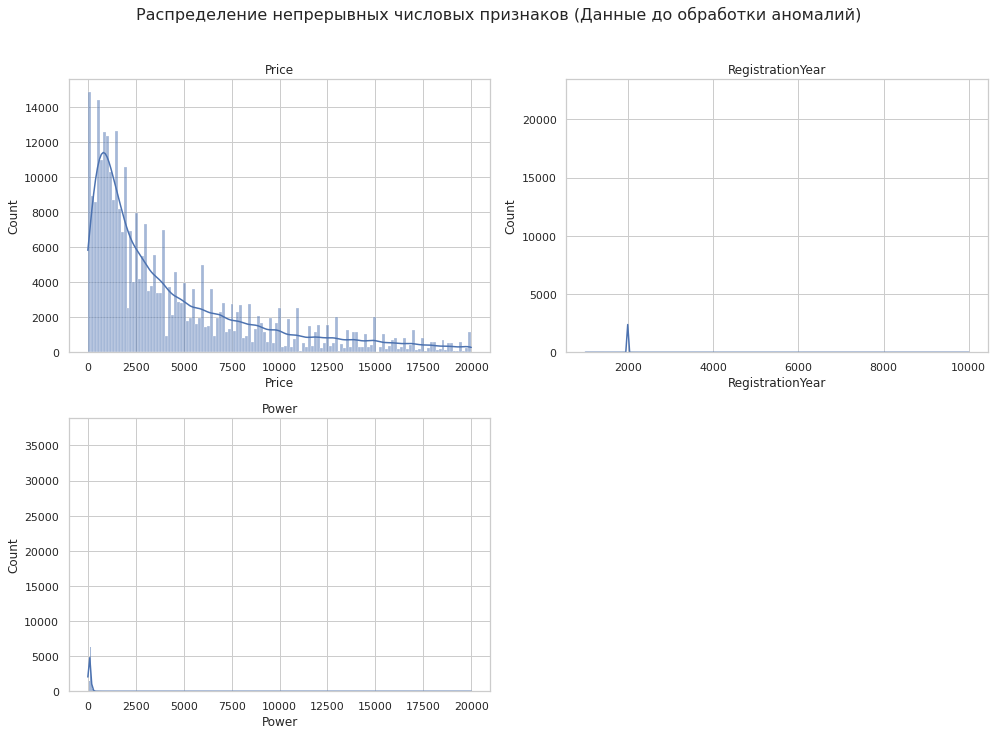

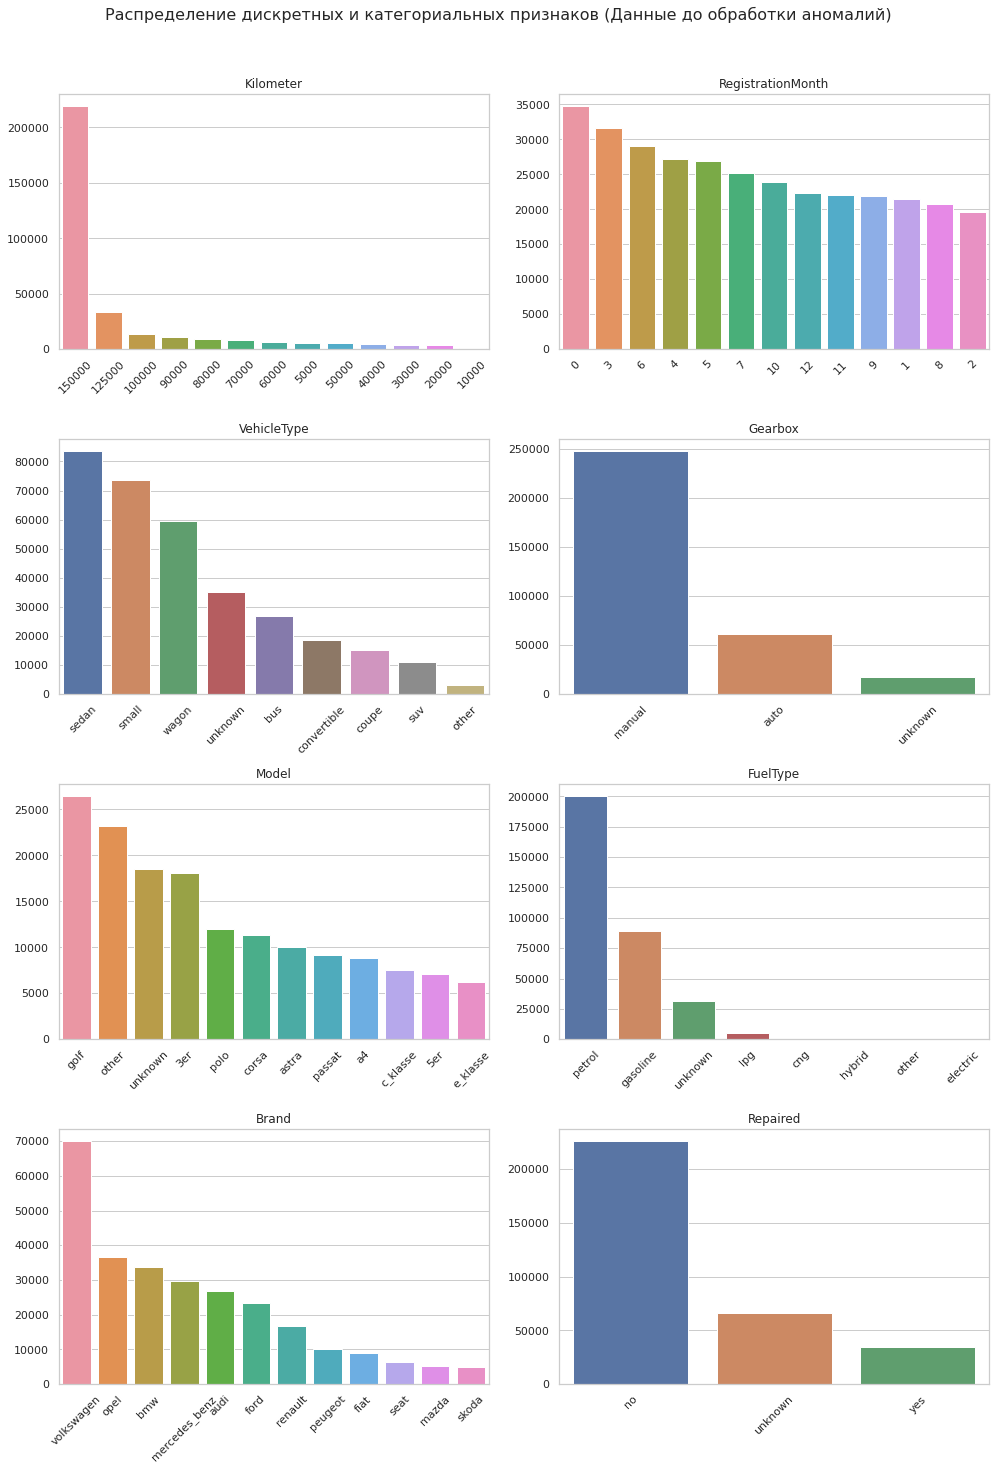

In [15]:
explore_dataframe(df, 'Данные до обработки аномалий')

**Явные проблемы:**

Числовые признаки:
- `RegistrationYear` и `Power` - необходимо обработать аномальные значения.
- `Price` - минимальное значение `0`. Такие записи не несут полезной информации для обучения модели (и искажают среднее, RMSE и распределение), поэтому их лучше удалить.
- `RegistrationMonth` - есть значение `0`. Скорее всего, в данных пропущенные месяцы были записаны как `0`. Можно заменить это значение на моду, либо оставить как есть. Лучше интерпретировать как «неизвестный месяц регистрации» и оставить без изменений.

Категориальные:
- `FuelType` - категории `other` и `unknown` дублируются по смыслу, можно их объединить. Значения `gasoline` и `petrol`, возмонжо, стоит объединить, нужно уточнять у заказчика. По смыслу это одно и то же.
- `VehicleType` - аналогично, категории `other` и `unknown` дублируются по смыслу.

#### `RegistrationYear`

In [16]:
# Ограничим для лучшей читаемости графика
valid_year_min = 1900
valid_year_max = 2025

RegistrationYear_temp = df['RegistrationYear'].apply(
    lambda x: x if valid_year_min <= x <= valid_year_max else np.nan
)

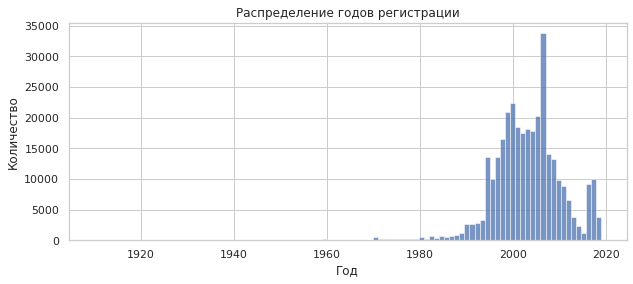

In [17]:
plt.figure(figsize=(10, 4))
sns.histplot(RegistrationYear_temp, bins=100, kde=False)
plt.title("Распределение годов регистрации")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

Оптимальный диапазон - 1980 ≤ `RegistrationYear` ≤ 2025. До 1980 плотность очень мала - это либо ретро, либо шум. После 2025 - заведомо ошибка, так как эти автомобили ещё не зарегистрированы. Пропуски можно сразу заменить на моду, чтобы не терять данные. 

In [18]:
# Фильтрация
df['RegistrationYear'] = df['RegistrationYear'].apply(
    lambda x: x if 1980 <= x <= 2025 else np.nan
)

# Замена пропусков модой
year_mode = df['RegistrationYear'].mode()[0]
df['RegistrationYear'] = df['RegistrationYear'].fillna(year_mode)

# Привести RegistrationYear обратно к int
df['RegistrationYear'] = df['RegistrationYear'].astype(int)

#### `Power`

Основная масса легковых авто лежит в диапазоне [50, 500] л.с. Можем установить интервал немного шире, учитывая редкие спорткары.

In [19]:
# Ограничим значения 
df['Power'] = df['Power'].apply(
    lambda x: x if 50 <= x <= 800 else np.nan
)

# Заполним пропуски модой
power_mode = df['Power'].mode()[0]
df['Power'] = df['Power'].fillna(power_mode)

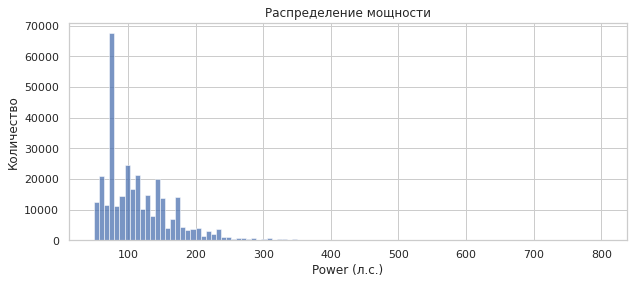

In [20]:
plt.figure(figsize=(10, 4))
sns.histplot(df['Power'], bins=100)
plt.title("Распределение мощности")
plt.xlabel("Power (л.с.)")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

#### `Price`

Здесь нужно убрать только бесплатные авто, в остальном значения выглядят корректно.

In [21]:
# Количество строк с Price = 0 
(df['Price'] == 0).sum()

9387

In [22]:
# Удалим эти строки
df = df[df['Price'] > 0]

#### `VehicleType` и `FuelType`

Объединим категории `other` и `others` с `unknown` в обоих столбцах.

In [23]:
# Объединяем 'other' и 'others' в 'unknown' для VehicleType и FuelType
df['VehicleType'] = df['VehicleType'].replace({'other': 'unknown', 'others': 'unknown'})
df['FuelType'] = df['FuelType'].replace({'other': 'unknown', 'others': 'unknown'})

# Проверка
print("VehicleType:", df['VehicleType'].unique())
print("FuelType:", df['FuelType'].unique())

VehicleType: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon']
FuelType: ['petrol' 'gasoline' 'unknown' 'lpg' 'hybrid' 'cng' 'electric']


#### Проверка

--- Анализ таблицы: Данные после обработки ---

Числовые признаки:



,count,mean,std,min,25%,50%,75%,max
Price,317439.0,4533.970700,4519.674833,1.0,1200.0,2849.0,6500.0,20000.0
RegistrationYear,317439.0,2003.436635,6.579124,1980.0,1999.0,2003.0,2008.0,2019.0
Power,317439.0,115.878742,52.411854,50.0,75.0,105.0,142.0,800.0
Kilometer,317439.0,128236.700594,37632.284870,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,317439.0,5.750116,3.700353,0.0,3.0,6.0,9.0,12.0



Категориальные признаки:



,Признак,Уникальных значений,Мода
0,VehicleType,8,sedan
1,Gearbox,3,manual
2,Model,251,golf
3,FuelType,7,petrol
4,Brand,40,volkswagen
5,Repaired,3,no


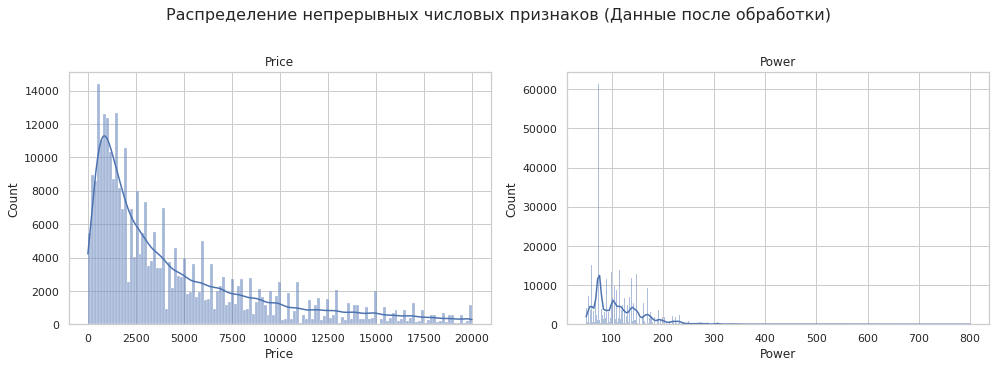

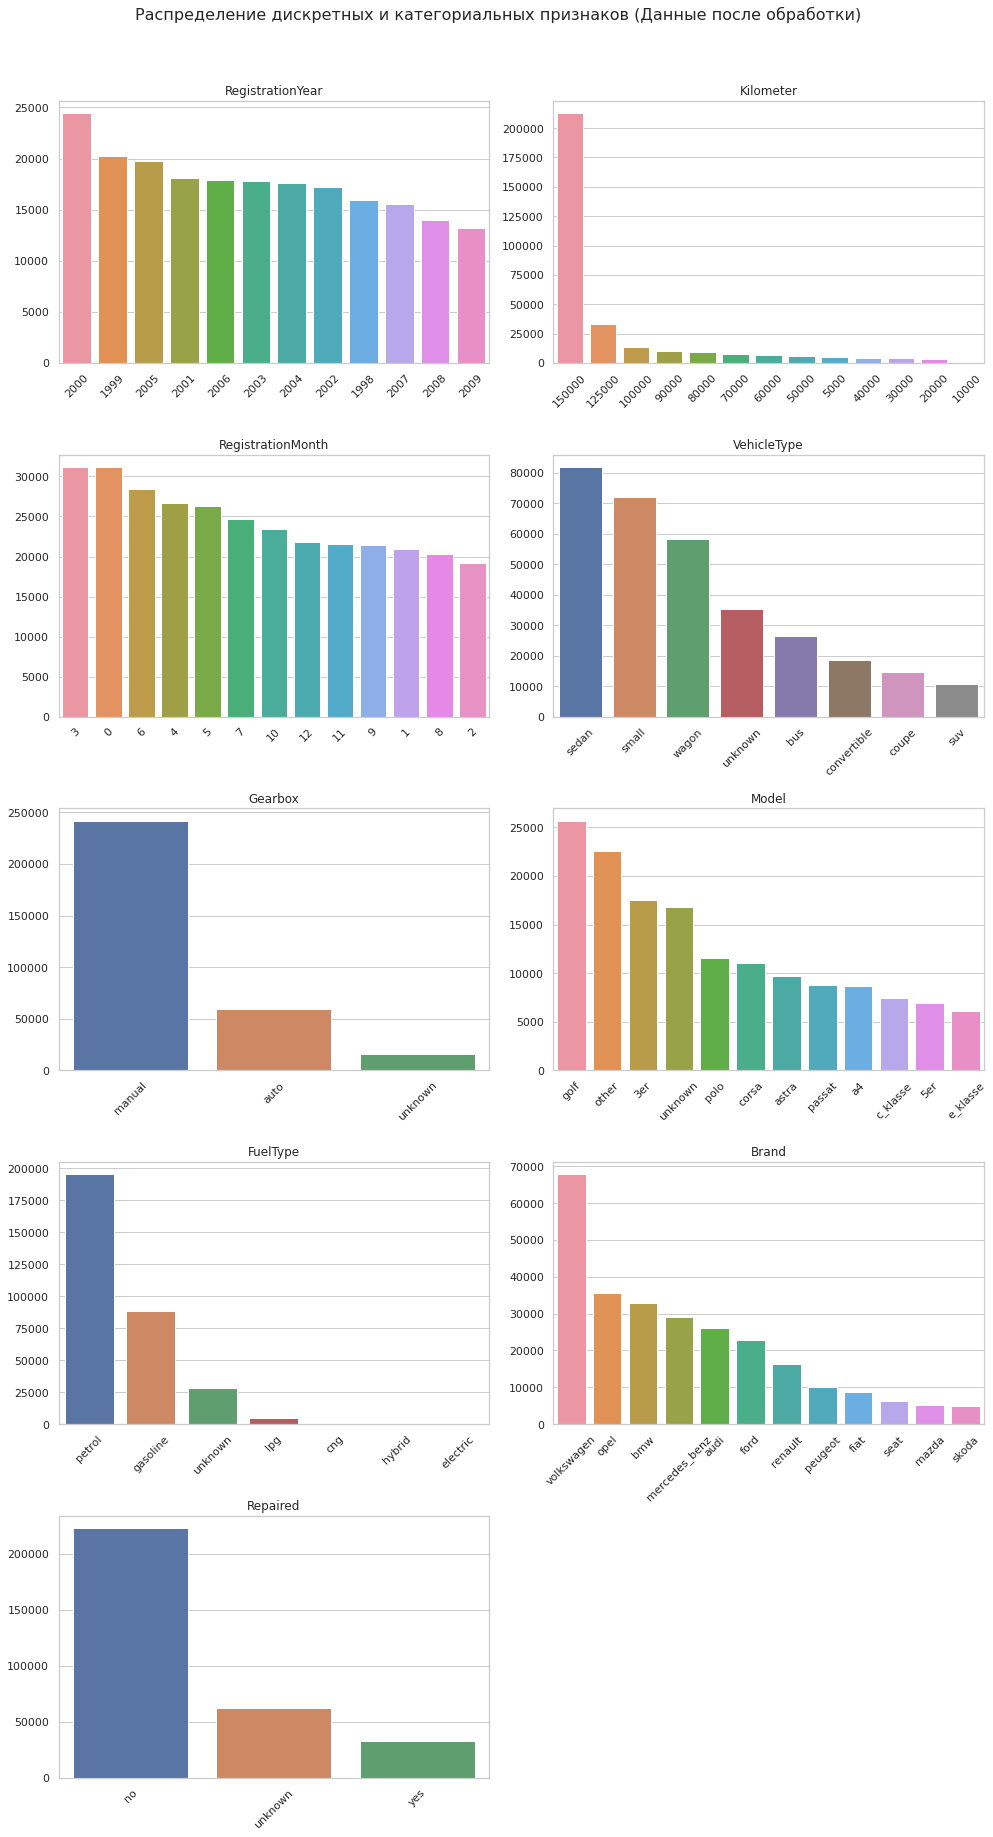

In [24]:
explore_dataframe(df, 'Данные после обработки')

Таким образом, мы провели EDA и окончательно очистили данные.

Для обучения моделей категориальные признаки необходимо закодировать. Признаки `RegistrationYear` и `RegistrationMonth`, несмотря на числовой тип, по смыслу являются категориальными (дискретные интервальные значения без количественного вклада) - поэтому их также будет целесообразно обработать как категории.
Все категориальные признаки будут закодированы с помощью `OneHotEncoding` и `OrdinalEncoding`.
Числовые непрерывные признаки масштабируются при необходимости (для модели SVR).

### Оценка корреляций

Изучим корреляцию между признаками и таргетом. 

In [25]:
# Строит графики корреляций 
def plot_feature_correlations(df, target='Price'):
    # Числовые переменные – только target и Power
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col in [target, 'Power']]
    
    # --- Спирмен для числовых ---
    if len(numeric_cols) > 1:
        corr_spearman = df[numeric_cols].corr(method='spearman')
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75})
        plt.title("Корреляция Спирмена: непрерывные признаки")
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно числовых признаков для корреляции.")

    # --- Phi-корреляция для категориальных ---
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    # Добавим RegistrationYear, RegistrationMonth, Kilometer как категориальные по смыслу
    cat_cols += ['RegistrationYear', 'RegistrationMonth', 'Kilometer', 'Model']

    # Оставим только те, что есть в данных и не содержат слишком много уникальных значений
    cat_cols = [col for col in cat_cols if col in df.columns and df[col].nunique() < 100]

    # Вычисление phi-корреляции
    phik_corr = df[[target] + cat_cols].phik_matrix(interval_cols=[target, 'Power'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(phik_corr[[target]].drop(target), annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={"shrink": .75})
    plt.title("Phi-корреляция с целевой переменной")
    plt.tight_layout()
    plt.show()

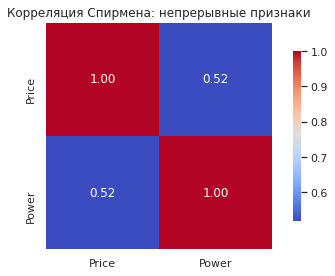

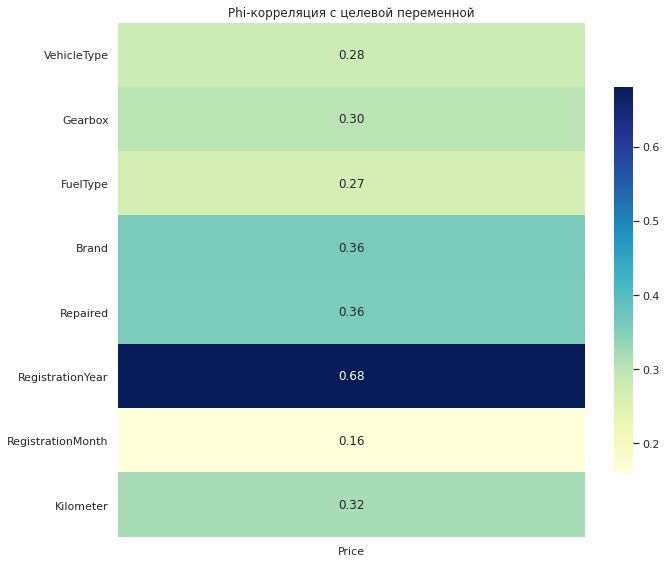

In [26]:
plot_feature_correlations(df)

Корреляционный анализ показал, что наибольшее влияние на цену оказывают год регистрации, мощность двигателя и информация о ремонте автомобиля. Признаки `Power` и `RegistrationYear` демонстрируют наибольшую числовую и категориальную корреляцию соответственно. Остальные признаки оказывают умеренное или слабое влияние, но также могут быть полезны для модели в совокупности.

На этапе подготовки данных были выполнены все необходимые шаги для обеспечения качества будущего моделирования. Удалены неинформативные признаки, заполнены пропуски в категориальных переменных значением `'unknown'`, а в числовых - модой. Проведена очистка от дубликатов и явных аномалий: исключены строки с нулевой ценой, ограничены допустимые значения года регистрации и мощности двигателя. Выполнен анализ распределений и корреляций, подтверждающий значимость ключевых переменных. Данные полностью подготовлены к этапу кодирования признаков, масштабирования и построения моделей.

## Обучение моделей

Данный раздел можно было бы сделать в виде одного пайплайна, но поскольку заказчику важно отслеживать время обучения и время предсказания моделей, разобьем его на небольшие блоки по всем моделям - так будет удобнее и нагляднее сравнивать время.

### Подготовка данных

Для перехода к этапу моделирования необходимо подготовить данные. План включает разбиение выборки на обучающую и тестовую, кодирование категориальных признаков и масштабирование числовых, если это требуется конкретной модели. Разбиение будет выполнено в соотношении 80/20/20. Для оценки качества моделей используется метрика RMSE, значение которой должно быть меньше 2500 согласно техническому заданию. Отдельно для каждой модели будут измеряться время обучения и предсказания с помощью команды `%%time`.

In [27]:
# Целевая переменная
target = 'Price'

# Признаки
X = df.drop(columns=[target])
y = df[target]

In [28]:
# Первый сплит: отделяем тестовую выборку (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Второй сплит: делим оставшиеся 80% на тренировочную (60%) и валидационную (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 от 80% = 20% от исходных данных
)

In [29]:
# Категориальные признаки (номинальные) — OHE
ohe_features = ['FuelType', 'Gearbox', 'Model', 'Brand', 'VehicleType', 'Repaired', 'RegistrationMonth']

# Порядковые категориальные признаки — Ordinal
ord_features = ['Kilometer', 'RegistrationYear']

# Числовые признаки (не категориальные и не порядковые)
num_features = ['Power']

In [30]:
# Порядки значений
kilometer_order = sorted(df['Kilometer'].unique())
year_order = sorted(df['RegistrationYear'].unique())

In [31]:
# Все категориальные признаки (номинальные + порядковые)
all_cat_features = ohe_features + ord_features

# Для деревянных моделей (RF, GB)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('ord', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                     unknown_value=-1))
        ]), all_cat_features),
    ],
    remainder='passthrough'
)

In [32]:
# Для SVR, Linear Regression
preprocessor_scaled = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_features),
    ('ord', OrdinalEncoder(categories=[kilometer_order, year_order]), ord_features),
    ('num', StandardScaler(), num_features)
], remainder='drop')  # только указанные признаки проходят

In [33]:
# Список для хранения результатов моделей
results = []

# Функция для оценки модели (при наличии предсказаний)
def evaluate_predictions(name, y_test, y_pred):
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE для модели {name}: {rmse:.2f}')
    results.append({'Модель': name, 'RMSE': round(rmse, 2)})

 ### Linear Regression (Ridge)

In [34]:
# Используем подготовленные данные с масштабированием
X_train_scaled = preprocessor_scaled.fit_transform(X_train)
X_val_scaled = preprocessor_scaled.transform(X_val)

# Параметры для перебора
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 10]
}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)

print("Лучший alpha:", grid.best_params_['alpha'])
print("Лучшее качество (CV RMSE):", -grid.best_score_)

Лучший alpha: 0.01
Лучшее качество (CV RMSE): 2622.259465536171


Для базовой модели с линейной зависимостью и регуляризацией результат очень достойный:
RMSE ≈ 2622 - чуть выше порога 2500

In [35]:
%%time

# Обучение модели (fit) с замером времени
ridge_best = Ridge(alpha=0.05)
ridge_best.fit(X_train_scaled, y_train)

CPU times: user 258 ms, sys: 25 µs, total: 258 ms
Wall time: 260 ms


Ridge(alpha=0.05)

In [36]:
%%time

# Предсказание (predict) с замером времени
y_pred_ridge = ridge_best.predict(X_val_scaled)

CPU times: user 4.32 ms, sys: 117 µs, total: 4.43 ms
Wall time: 2.49 ms


In [37]:
# Оценка качества (RMSE)
evaluate_predictions('Ridge Regression', y_val, y_pred_ridge)

RMSE для модели Ridge Regression: 2609.42


Модель линейной регрессии с L2-регуляризацией (Ridge) показала RMSE = 2609.42, что немного превышает заданный порог в 2500, но остаётся близким к нему. Обучение модели заняло всего 266 мс, а предсказание - около 2 мс, что делает её крайне быстрой и лёгкой в использовании. Несмотря на простоту, Ridge-регрессия обеспечивает стабильное качество и служит хорошей отправной точкой для сравнения с более сложными моделями.

### RandomForest

In [38]:
# Без масштабирования
X_train_tree = preprocessor_tree.fit_transform(X_train)
X_val_tree = preprocessor_tree.transform(X_val)

In [39]:
%%time

# Обучение
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tree, y_train)

CPU times: user 59.7 s, sys: 1.01 s, total: 1min
Wall time: 1min


RandomForestRegressor(n_jobs=-1, random_state=42)

In [40]:
%%time

# Предсказание
y_pred_rf = rf_model.predict(X_val_tree)

CPU times: user 3.41 s, sys: 0 ns, total: 3.41 s
Wall time: 3.42 s


In [41]:
# Оценка
evaluate_predictions('Random Forest', y_val, y_pred_rf)

RMSE для модели Random Forest: 1772.96


### LightGBM

In [42]:
# Преобразуем категориальные признаки в тип 'category'
for col in ohe_features + ord_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Параметры для перебора
lgbm_params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [300, 500],
    'categorical_feature': [all_cat_features]  # Указываем имена категориальных признаков
}

lgbm_model = LGBMRegressor(random_state=42, verbose=-1)

grid_lgbm = GridSearchCV(
    lgbm_model,
    lgbm_params,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_lgbm.fit(X_train, y_train)

print("Лучшие параметры (LightGBM):", grid_lgbm.best_params_)
print("Лучшее качество (CV RMSE):", -grid_lgbm.best_score_)

Лучшие параметры (LightGBM): {'categorical_feature': ['FuelType', 'Gearbox', 'Model', 'Brand', 'VehicleType', 'Repaired', 'RegistrationMonth', 'Kilometer', 'RegistrationYear'], 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
Лучшее качество (CV RMSE): 1684.0467015944744


In [43]:
%%time

# Обучение
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)

lgbm_model.fit(X_train, y_train, categorical_feature=all_cat_features)

CPU times: user 18.5 s, sys: 66.2 ms, total: 18.6 s
Wall time: 19.1 s


LGBMRegressor(max_depth=8, n_estimators=500, random_state=42)

In [44]:
%%time

# Предсказание
y_pred_lgbm = lgbm_model.predict(X_val)

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.79 s


In [45]:
# Оценка
evaluate_predictions('LightGBM', y_val, y_pred_lgbm)

RMSE для модели LightGBM: 1646.07


### CatBoost

In [46]:
# Подбор гиперпараметров
cat_params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [300, 500]
}

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

grid_cat = GridSearchCV(
    cat_model,
    cat_params,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_cat.fit(X_train, y_train, cat_features=all_cat_features)

print("Лучшие параметры (CatBoost):", grid_cat.best_params_)
print("Лучшее качество (CV RMSE):", -grid_cat.best_score_)

Лучшие параметры (CatBoost): {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}
Лучшее качество (CV RMSE): 1707.6818672421284


In [47]:
%%time

# Обучение
cat_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

cat_model.fit(X_train, y_train, cat_features=all_cat_features)

CPU times: user 3min 25s, sys: 1.98 s, total: 3min 27s
Wall time: 3min 28s


In [48]:
%%time

# Предсказание
y_pred_cat = cat_model.predict(X_val)

CPU times: user 573 ms, sys: 0 ns, total: 573 ms
Wall time: 571 ms


In [49]:
# Оценка
evaluate_predictions('CatBoost', y_val, y_pred_cat)

RMSE для модели CatBoost: 1673.12


На этапе моделирования были реализованы четыре модели: Ridge-регрессия, Random Forest, CatBoost и LightGBM. Для каждой модели выполнено обучение, предсказание и оценка качества с помощью метрики RMSE. Кроме того, замерено время обучения и предсказания с использованием команды `%%time`, что позволяет учитывать требования заказчика к производительности. Почти все модели показали RMSE ниже допустимого порога (2500), причём наилучшие результаты продемонстрировали модели градиентного бустинга - LightGBM и CatBoost.

## Анализ моделей

In [50]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('RMSE'))

,Модель,RMSE
2,LightGBM,1646.07
3,CatBoost,1673.12
1,Random Forest,1772.96
0,Ridge Regression,2609.42


Проведено сравнение четырёх моделей: линейной регрессии (Ridge), случайного леса, CatBoost и LightGBM. Почти все модели прошли порог качества RMSE < 2500, установленный заказчиком.

Наихудшее качество показала модель Ridge Regression (RMSE ≈ 2609.42), однако она остаётся самой быстрой по обучению и предсказанию, что делает её пригодной для базовой оценки.

Модели градиентного бустинга - CatBoost и LightGBM - продемонстрировали наилучшие значения метрики. После подбора гиперпараметров:
- CatBoost достиг RMSE ≈ 1673.12 при времени обучения ~3.5 мин и предсказания < 1 сек;
- LightGBM - RMSE ≈ 1646.07 при времени обучения ~19 сек и предсказания ~3 сек.

Random Forest показал RMSE ≈ 1772.96, время обучения составило ~ 1 мин., модель тоже является достаточно практичной, немного уступая бустингам по качеству прогнозов.

Таким образом, **LightGBM** с подобранными параметрами показал лучший результат по качеству, минимально опередив CatBoost. Оба бустинга являются предпочтительными для развёртывания, учитывая высокое качество и умеренное время работы.

## Тестирование лучшей модели

Проверим лучшую модель на тестовой выборке.

In [51]:
# Преобразуем категориальные признаки в 'category' (как в X_train)
for col in all_cat_features:
    X_test[col] = X_test[col].astype('category')

# Предсказание на тестовой выборке
y_test_pred = lgbm_model.predict(X_test)

# Оценка
evaluate_predictions('LGBM', y_test, y_test_pred)

RMSE для модели LGBM: 1653.60


<Figure size 720x432 with 0 Axes>

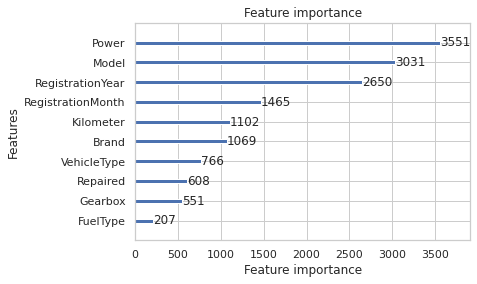

In [52]:
# Важность признаков
plt.figure(figsize=(10, 6))
plot_importance(lgbm_model)
plt.show()

LightGBM показал стабильное качество на тестовых данных с RMSE 1653.60, что согласуется с результатами кросс-валидации (1646.07), подтверждая надежность модели. Анализ важности признаков выявил четкие закономерности: мощность автомобиля (`Power`) оказалась ключевым фактором с максимальным влиянием на предсказание, модель автомобиля (`Model`) и год регистрации (`RegistrationYear`) также продемонстрировали значимый вклад. Такие признаки как тип топлива (`FuelType`) и коробка передач (`Gearbox`) имели минимальное влияние, что указывает на их второстепенную роль в прогнозировании цены. Полученные результаты не только подтверждают эффективность LightGBM для данной задачи, но и предоставляют ценную информацию о структуре данных, которая может быть использована для дальнейшего улучшения модели. Стабильность метрик на тестовой выборке и интерпретируемость важности признаков делают **LightGBM** оптимальным выбором для практического применения.